4a (conversion factor is 10)

In [53]:
import numpy as np
import matplotlib.pyplot as plt
Rmin = 4.60209439806843 #A

In [54]:
def pot(r1,r2):
    sig = 0.41 #nm
    eps = 1.77 #kJ/mol
    Rij = np.sum((r1-r2)**2)**0.5 #distance in nm
    U = 4*eps*(((sig/Rij)**12)-((sig/Rij)**6)) #kJ/mol
    return U

In [55]:
def position(n): # in nm
    atomposition = np.array([])
    for i in range(0, n):
        for j in range(0, n):
            for k in range(0, n):
                atomrow = np.array([i, j, k]) * Rmin *0.1
                atomposition = np.append(atomposition, atomrow)
    atomposition = np.reshape(atomposition, (n**3, 3))
    return atomposition  #in nm  

In [56]:
def calcforce(p1,p2):
    sig = 0.41 #nm
    eps = 1.77 #kJ/mol
    Rij = np.sum((p1-p2)**2)**0.5 # in nm
    F = ((4*eps*(((-12*sig**12)/(Rij**13))+((6*sig**6)/(Rij**7)))) * ((p1 - p2)/Rij)) * (-1)
    return F # kJ/(mol*nm)

In [57]:
def totforcematrix(cube):    
    atomforce3 = np.array([])
    totalforce = np.array([0, 0, 0])
    for i in range(0, np.shape(cube)[0]):
        for j in range(0, np.shape(cube)[0]):
            if i != j:
                Fi = calcforce(cube[i], cube[j])
                totalforce = np.add(Fi, totalforce)

        atomforce3 = np.append(atomforce3, totalforce)
        totalforce = np.array([0, 0, 0])
    atomforce3 = np.reshape(atomforce3, (np.shape(cube)[0], 3))
    return atomforce3

In [58]:
def penergycube(cube): #total PE for each step
    TotalE = 0
    for i in range(0, np.shape(cube)[0]):
        for j in range(0, np.shape(cube)[0]):
            if i != j:
                TotalE += pot(cube[i], cube[j])
    TotalE = TotalE/2
    return TotalE

In [59]:
def kenergycube(v_curr, mass): #total KE for each step
    KE = 0.0
    for i in range(v_curr.shape[0]):
        KE += 0.5*(mass[i]*np.sum(v_curr[i]**2))
    return KE

4b

In [60]:
def vchange(forcematrix, mass, timestep):
    v_curr = (forcematrix / mass) * timestep 
    return v_curr #in nm/ps if force is kJ/mol mass is g/mol and time step is ps

4c

In [61]:
def rchange(v_curr, timestep, forcematrix, mass):
    r_change = (v_curr * timestep) + (0.5 * forcematrix * mass * timestep**2)
    return r_change #nm if vel is nm/ps, timestep is ps, force is kJ/mol, mass g/mol

4d

In [62]:
def MDcalc(positions, masses, velocities, dt, steps, using_velocity_verlet): #nm, g/mol, nm/ps, ps, steps, True for vel, anything else for euler
    r_curr = positions.copy()
    v_curr = velocities.copy()
    r_traj = np.array([])
    v_traj = np.array([])
    pe_traj = np.array([])
    ke_traj = np.array([])
    for step in range(steps):
        r_traj = np.append(r_traj, r_curr)
        v_traj = np.append(v_traj, v_curr)
        if step == 0 or not using_velocity_verlet:
            potential = penergycube(r_curr)
            f_curr = totforcematrix(r_curr)
        kinetic = kenergycube(v_curr, masses)
        pe_traj = np.append(pe_traj, potential)
        ke_traj = np.append(ke_traj, kinetic)
        a_curr = f_curr / masses
        r_next = r_curr + (v_curr * dt) + (0.5 * a_curr * (dt**2))
        if using_velocity_verlet:
            pot_next = penergycube(r_next)
            f_next = totforcematrix(r_next)
            a_next = f_next / masses
            v_next = v_curr + 0.5*(a_curr + a_next)*dt
            f_curr = f_next.copy()
            potential = pot_next
        else:
            v_next = v_curr + a_curr*dt
        r_curr = r_next.copy()
        v_curr = v_next.copy()
  
    return r_traj, v_traj, pe_traj, ke_traj

4e (Euler)

In [67]:
# dt 0.002ps, 50ps or 25000 steps
in_positions = position(3) #nm

mass_array = np.ones((np.shape(in_positions)[0],1)) * 131.29 #g/mol

in_velocity = np.zeros(((np.shape(in_positions)[0]),3))

r_traj_4e, v_traj_4e, pe_traj_4e, ke_traj_4e = MDcalc(in_positions, mass_array, in_velocity, 0.002, 25000, False)


with open('trajectory4e.xyz', 'w') as f:
    for frame in range(r_traj_4e.shape[0]):
        if frame%50 != 0: continue
        print("%i" % r_traj.shape[1], file=f)
        print("Frame %i" % frame, file=f)
        for atom in range(r_traj.shape[1]):
            print("Xe % 12.6f % 12.6f % 12.6f" % (r_traj[frame][atom][0] * 10,r_traj[frame][atom][1] * 10,r_traj[frame][atom][2] * 10), file=f)

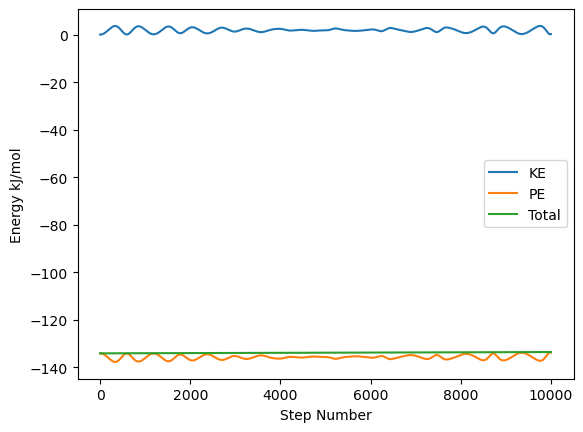

In [68]:
total_traj_4e = ke_traj_4e + pe_traj_4e
n_steps = range(0,25000)
fig, ax = plt.subplots()
ax.plot(n_steps, ke_traj_4e, label = 'KE')
ax.plot(n_steps, pe_traj_4e, label = 'PE')
ax.plot(n_steps, total_traj_4e, label = 'Total')
ax.set_xlabel('Step Number')
ax.set_ylabel('Energy kJ/mol')
ax.legend()

plt.show()

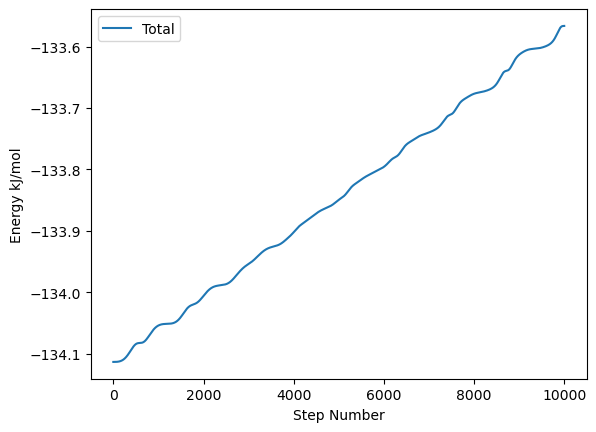

In [69]:
total_traj_4e = ke_traj_4e + pe_traj_4e
n_steps = range(0,25000)
fig, ax = plt.subplots()
ax.plot(n_steps, total_traj_4e, label = 'Total')
ax.set_xlabel('Step Number')
ax.set_ylabel('Energy kJ/mol')
ax.legend()

plt.show()

4f (ke and pe plots)

In [ ]:
#ke and pe of 0.001ps 50000 steps
r_traj_4fs, v_traj_4fs, pe_traj_4fs, ke_traj_4fs = MDcalc(in_positions, mass_array, in_velocity, 0.001, 50000, False)

total_traj_4fs = ke_traj_4fs + pe_traj_4fs
n_steps = range(0,50000)
fig, ax = plt.subplots()
ax.plot(n_steps, ke_traj_4fs, label = 'KE')
ax.plot(n_steps, pe_traj_4fs, label = 'PE')
ax.plot(n_steps, total_traj_4fs, label = 'Total')
ax.set_xlabel('Step Number')
ax.set_ylabel('Energy kJ/mol')
ax.legend()

plt.show()

In [ ]:
n_steps = range(0,50000)
fig, ax = plt.subplots()
ax.plot(n_steps, total_traj_4fs, label = 'Total')
ax.set_xlabel('Step Number')
ax.set_ylabel('Energy kJ/mol')
ax.legend()

plt.show()

In [ ]:
#ke and pe of 0.005ps or 10000 steps
r_traj_4fb, v_traj_4fb, pe_traj_4fb, ke_traj_4fb = MDcalc(in_positions, mass_array, in_velocity, 0.005, 10000, False)

total_traj_4fb = ke_traj_4fb + pe_traj_4fb

n_steps = range(0,10000)
fig, ax = plt.subplots()
ax.plot(n_steps, ke_traj_4fb, label = 'KE')
ax.plot(n_steps, pe_traj_4fb, label = 'PE')
ax.plot(n_steps, total_traj_4fb, label = 'Total')
ax.set_xlabel('Step Number')
ax.set_ylabel('Energy kJ/mol')
ax.legend()

plt.show()
#describe what happens to total energy as function of time

In [ ]:
fig, ax = plt.subplots()
ax.plot(n_steps, total_traj_4fb, label = 'Total')
ax.set_xlabel('Step Number')
ax.set_ylabel('Energy kJ/mol')
ax.legend()

plt.show()

As time goes on using the Euler algorithm, the total energy seems to be changing when it
should theoretically stay constant through the whole simulation. This is due to the lack
of accuracy in the velocty update as the MD calculation iterates through each step. 

4g velocity verlet

In [79]:
# dt 0.002 25000 steps
r_traj_4g, v_traj_4g, pe_traj_4g, ke_traj_4g = MDcalc(in_positions, mass_array, in_velocity, 0.002,25000, True)


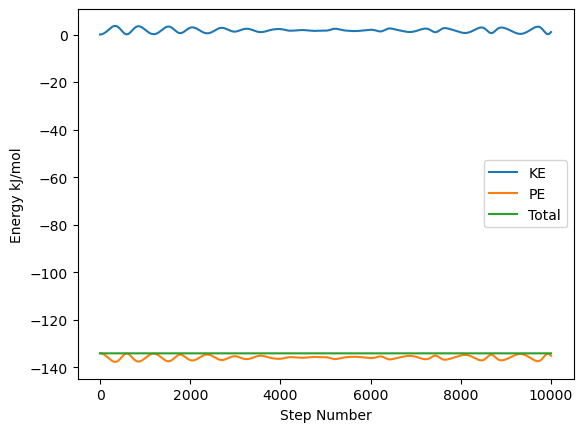

In [80]:
#ke and pe graph
n_steps = range(0,25000)

total_traj_4g = ke_traj_4g + pe_traj_4g

fig, ax = plt.subplots()
ax.plot(n_steps, ke_traj_4g, label = 'KE')
ax.plot(n_steps, pe_traj_4g, label = 'PE')
ax.plot(n_steps, total_traj_4g, label = 'Total')
ax.set_xlabel('Step Number')
ax.set_ylabel('Energy kJ/mol')
ax.legend()

plt.show()

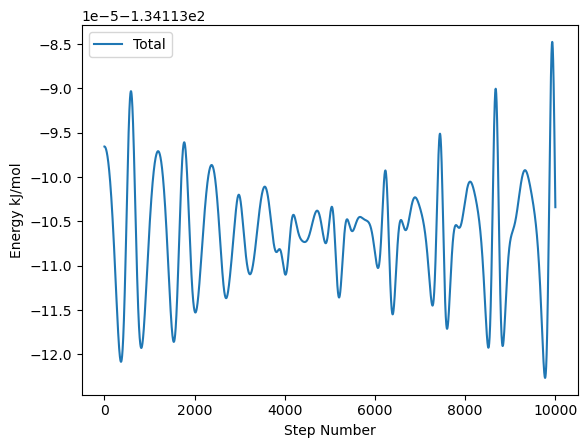

In [81]:
fig, ax = plt.subplots()

ax.plot(n_steps, total_traj_4g, label = 'Total')
ax.set_xlabel('Step Number')
ax.set_ylabel('Energy kJ/mol')
ax.legend()

plt.show()

the total energy seems to stay more constant at the end of the simulation. Success!